## Using Convolutional Variational Auto Encoders to Play With Faces
### Jibben Hillen
#### Deep Learning for Computer Vision final project

For this project, I successfully implemeneted a pixel-wise-loss-based CVAE and trained it on the CelebA dataset of faces. While all faces in this dataset are (mostly) centered similarly and (mostly) cropped similarly, there is a lot of variation in the orientation of faces, facial expressions, backgrounds, obscuring objects, and other potential difficulties. I wanted to create a relatively rigorous net, so I did not do any pre-processing or filtering of this dataset past what the creators already performed.

To start, I knew I wanted to do something with a generative aspect. I toyed around with a more novel use of variational autoencoders, first planning on scraping a very large number of watercolors paintings from flickr / instagram / reddit, but this turned out to be infeasible. First of all, only about 50% of images from watercolor groups or tagged as watercolor were actually just of the painting. Most had other objects in them, either next to or obscuring the painting. Second, Flickr limits scraping pretty heavily and Instagram makes it near impossible. After both some automated and manual cleaning of images, I had a dataset of a few thousand images. Due to the complexity of the space, this did not prove to be enough to get anything interesting from a generative perspective.

I decided to stick with VAEs and apply them to a more established dataset, working up from MNIST data (where you can get pretty solid recreation from only a few dimensions!) to the Oxford 102 flower dataset (which I played with the least) to the CelebA face dataset. I include an example of an MNIST in Appendix A of this notebook. The main part will just be my successful pixel-wise-loss CVAE.

Speaking of appendices, I also played around with a perceptual loss functiion for the CVAE. For humans, a slight rotation of the head or translation in the image would not be considered as a big difference. For our pixel-wise loss, it would be completely wrong, which is not the result we are looking for. To do this, I tried comparing the distances of the output of intermadiate layers of a pre-trained VGG net when processing input and decoded images. Despite my best efforts, I could not get this loss to work correctly - it would not change at all during backpropogation. This could be a good area for potential future work.

Second, I also attempted to create a generative adversarial network. I was not happy about the amount of mode collapse I was seeing from my variational auto-encoder. This was a pretty last minute attempt, as as such I was not able to get it to converge to any sort of useful state. The output always just stabalized around some colorful noise (perhaps this could make a nice modern art exhibit - the output of failed generative net).

The cool thing about using a VAE, which is not the case for traditional GANs, is that each photo gets encoded to a latent space. On that latent space, you can perform vector math. As such, the encoder part of the VAE does something similar to an imagined Image2Vec. Because the CelebA dataset has image labels, we can calculate the means for various labels and make encoded images female/male, smile/not smile, etc. Or at least in theory! The results of this vector-space manipulation can also be seen below.

With all that said, let's get to some code! First we will import as necessary packages and make sure we are set up correctly with keras and numpy

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from functools import partial, reduce
import os.path
import os
import h5py
import math
import random
import csv

from PIL import Image
from scipy.ndimage import imread

from keras.layers import Flatten, Reshape, Input, Dense, Lambda, Dropout, Activation, BatchNormalization
from keras.layers import Conv2D, Conv2DTranspose, MaxPooling2D, ZeroPadding2D, UpSampling2D
from keras.models import Model, Sequential
from keras.callbacks import TensorBoard, ModelCheckpoint, Callback
from keras.metrics import binary_crossentropy
from keras.engine.topology import Layer
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.advanced_activations import LeakyReLU
import keras.optimizers
from keras import backend as K

K.set_floatx('float32')
K.set_image_dim_ordering('tf')

%matplotlib inline

Using TensorFlow backend.


We will define a constant seed to we can get consistent runs over different nets

In [2]:
np.random.seed(2218)

### Convolutional Variational Auto Encoder

The only architecture I successfully created was a CVAE with a pixel-wise loss function. Here we will go about setting up the code for this. I made all of this code very modular and flexible, so the same net can be used for almost any dataset! We can set up a net, compile it, and train it with only a few lines of code, as I will show soon. First, let's begin with a custom callback and a custom layer type.

This ImageSaver class is a custom callback I created to save the image at each step. We can add this callback to a keras training session and sample images will be encoded and decoded at the end of every epoch.

In [3]:
class ImageSaver(Callback):
    ''' Keras Callback to save demo images after each epoch'''
    def __init__(self, image_path, images, shape, period=1, inp_path=None, out_path=None):
        # we init this with a given set of images so we can watch faces evolve
        self.images = images
        self.batch_size = images.shape[0]
        self.image_path = image_path
        if shape[2] == 1:
            self.shape = (shape[0], shape[1])
        else:
            self.shape = shape
        self.period = period
        
        # we also have the option of sharing the numpy vecs for the input / output at each step
        # this allows for more flexibility with visualizations
        self.inp_path = inp_path
        self.out_path = out_path

        if inp_path:
            np.save(self.inp_path, self.images)
        
        # and here we just make sure our image is the right size
        self.dpi = 128
        self.fig_size = ((max(shape[0], 128)* 12) // self.dpi, int(max(shape[1], 128) * 2 * self.batch_size / 3) // self.dpi)

        super(ImageSaver, self).__init__()

    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.period == 0:
            # we have to use batch_size = 1 to avoid the batch_normalization!
            vecs = self.model.layers[1].predict(self.images, batch_size=1, verbose=0)
            pred = self.model.layers[2].predict(vecs, batch_size=1, verbose=0)

            if self.out_path:
                np.save(self.out_path.format(epoch=epoch), pred)

            fig = plt.figure(figsize=self.fig_size)

            # Show every decoded image next to its original input
            for i in range(self.batch_size):
                a = fig.add_subplot(self.batch_size // 3 + 1, 6, i * 2 + 1)
                a.spines['top'].set_color('none')
                a.spines['bottom'].set_color('none')
                a.spines['left'].set_color('none')
                a.spines['right'].set_color('none')
                a.tick_params(labelcolor='w', top='off', bottom='off', left='off', right='off')
                a.imshow(self.images[i].reshape(self.shape), interpolation='nearest')
                if i < 3:
                    a.set_title('input')

                a = fig.add_subplot(self.batch_size // 3 + 1, 6, i * 2 + 2)
                a.spines['top'].set_color('none')
                a.spines['bottom'].set_color('none')
                a.spines['left'].set_color('none')
                a.spines['right'].set_color('none')
                a.tick_params(labelcolor='w', top='off', bottom='off', left='off', right='off')
                a.imshow(pred[i].reshape(self.shape), interpolation='nearest')
                if i < 3:
                    a.set_title('decoded')

            fig.savefig(self.image_path.format(epoch=epoch), bbox_inches='tight', dpi=self.dpi) 

            

Next, we create a custom loss layer to calculate our CVAE loss. Keras isn't powerful to handle a loss function that would incorporate Kullback Liberler divergence into the loss function. As such, we make the output of this layer the loss for the entire net.

In [4]:
class CVAELossLayer(Layer):

    def __init__(self, latent_dim, image_size, kl_lambda=1, pixel_lambda=1, **kwargs):
        # we have to init with image_size and latent_dim for later calculations
        # furthermore, we allow custom tweaking of how much importance give give to the
        # KL divergence vs the binary_crossentropy between the input image and the decoded image
        
        self.latent_dim = latent_dim
        self.image_size = image_size
        
        self.kl_l = kl_lambda
        self.px_l = pixel_lambda
        
        self.is_placeholder = True
        
        super(CVAELossLayer, self).__init__(**kwargs)

    def calculate_loss(self, inputs):
        x = inputs[0]
        z_mean = inputs[1][:,:self.latent_dim]
        z_log_sigma = inputs[1][:,self.latent_dim:]
        dec_x = inputs[2]
        
        # we add 1e-10 to avoid any possible overflow due to the log calculated within binary_crossentropy
        output_loss = self.image_size * K.mean(K.binary_crossentropy(dec_x + 1e-10, x + 1e-10), axis=-1)
        
        # this is the Kullback Libeler divergence between the distribution in latent space and a ~N(0,1)
        latent_loss = - 0.5 * K.sum(1 + K.clip(z_log_sigma, 1e-10, 1e10) - K.clip(K.square(z_mean), 1e-10, 1e10) - K.clip(K.exp(z_log_sigma), 1e-10, 1e10), axis = -1)
        
        return K.mean(output_loss * self.px_l + latent_loss * self.kl_l)
    
    
    def call(self, inputs):
        return self.calculate_loss(inputs)
    
    def compute_output_shape(self, input_shape):
        return (input_shape[0][0], 1)

Before we get to our net, let us define some helper functions for building

In [5]:
# helper function to ensure we have the right amount of padding during deconvolution
def build_padding(v_rem, h_rem, mult):
    lay = None
    
    v_pad = 0
    h_pad = 0
    
    if v_rem >= mult:
        v_rem -= mult
        v_pad = 1

    if h_rem >= mult:
        h_rem -= mult
        h_pad = 1
    
    if h_pad or v_pad:
        lay = ZeroPadding2D(padding=(v_pad, h_pad))
        
    return lay, v_rem, h_rem

In [6]:
# we gotta have functions for our Lambda sampling layer.
# This is the reparameterization trick that allows us to actually train the net
def dist_sample(latent_dims, inputs):
    z_mean = inputs[:,:latent_dims]
    z_log_sigma = inputs[:,latent_dims:]

    eps = K.random_normal(shape=(latent_dims,), mean=0.0, stddev=1.0, dtype='float32')
    
    return z_mean + (K.exp(z_log_sigma) * eps)

def sample_output_shape(input_shape):
    shape = list(input_shape)
    assert len(shape) == 2
    shape[1] //= 2
    return tuple(shape)

And finally the code to build the net itself! First we define the structure of our encoder and decoder, which is shared regardless of if we are using a VGG-CVAE or a vanilla CVAE. We use the following networks structures:

#### Encoder:
4 layers of (Convolution, BatchNormaliaztion, LeakyReLU activation, MaxPooling), followed by a dense layer of *int_dim* nodes and a dense layer of 2 x *latent_dim* nodes. (I use a LeakyRelU with an alpha of 0.1, which I found to give better results than a normal ReLU. Furthermore, we use BatchNormalization with a very high momentum compared to what is frequently used, because the images are generally unrelated. Regardless, the use of this BatchNormalization also provides better results. I will demonstrate a comparison below of a net using a LeakyReLU with BatchNormalization against a net with vanilla ReLU and no BatchNormalization.) We use 2 x *latent_dim*, becuase the first half of the output vector will be the mean in the latent space and the second half will be the variance in the latent space for each dimension. Note that we don't have any activation function on the final dense layer, which proved to give better results through testing

#### Decoder:
First we use a Lambda layer to sample a value from the mean and variance given. This is the reparameterization trick that allows the net to train. This creates a vector with length *latent_dim*. Then, we use a dense layer to increase it to size *int_dim*. Then, another dense layer is used to increase the dimensions closer to that of the output image. After this, 4 layers of (DeConvolution, BatchNormalization, LeakyRelU) are used to increase the image size to double that of the desired output. Again, the use of LeakyReLUs and BN seemed to create a better network. Finally, we use a single layer of (MaxPooling, Convolution w/ sigmoid activation) to create our output image.

In [7]:
def build_encoder(image_shape, latent_dim, int_dim, num_k, k_size, alpha=0.1, momentum=0.9, dropout=0.25):
    '''
    Function to build the encoder net
    This function is flexible and can use the input parameters to customize parameters of the net
    '''
    
    p_params= {'pool_size' : (2,2), 'strides' : (2,2), 'padding' : 'same'}

    inp = Input(shape=image_shape)

    # just a series of convolutions and poolings to get the size down
    x = Conv2D(num_k, (k_size, k_size), padding='same')(inp)
    if dropout > 0:
        x = BatchNormalization(momentum=momentum)(x)
    x = LeakyReLU(alpha=alpha)(x)
    x = MaxPooling2D(**p_params)(x)

    x = Conv2D(num_k * 2, (k_size, k_size), padding='same')(x)
    if dropout > 0:
        x = BatchNormalization(momentum=momentum)(x)
    x = LeakyReLU(alpha=alpha)(x)
    x = MaxPooling2D(**p_params)(x)

    x = Conv2D(num_k * 4, (k_size, k_size), padding='same')(x)
    if dropout > 0:
        x = BatchNormalization(momentum=momentum)(x)
    x = LeakyReLU(alpha=alpha)(x)
    x = MaxPooling2D(**p_params)(x)

    x = Conv2D(num_k * 4, (k_size, k_size), padding='same')(x)
    if dropout > 0:
        x = BatchNormalization(momentum=momentum)(x)
    x = LeakyReLU(alpha=alpha)(x)
    x = MaxPooling2D(**p_params)(x)
    
    # then we flatten, and have a dense layer as output
    flat = Flatten()(x)
    flat = Dense(int_dim, activation='relu')(flat)
    flat = Dropout(dropout)(flat)
    
    encoded = Dense(latent_dim * 2)(flat)

    return Model(inp, encoded)

def build_decoder(image_shape, latent_dim, int_dim, num_k, k_size, alpha=0.1, momentum=0.9, dropout=0.25):
    '''
    Function to build the decoder net
    This function is flexible and can use the input parameters to customize parameters of the net
    '''

    # figure out what dimension we want to start with
    # and how much remainder we'll have (for padding)
    v_dim = image_shape[0] // 8
    h_dim = image_shape[1] // 8
    v_rem = image_shape[0] - (v_dim * 8) + 1
    h_rem = image_shape[1] - (h_dim * 8) + 1
    
    # build a layer to sample from the given probability distribution
    sample_func = partial(dist_sample, latent_dim)
    # sometimes python is kind of dumb
    # like right now, partial functions don't have names which messes up keras
    # so let's manually add one
    sample_func.__name__ = 'decoder_sample_func'
    
    # get input
    inp = Input(shape=(latent_dim*2,))
    sample = Lambda(sample_func, output_shape = sample_output_shape)(inp)
    
    # upscale with dense, use some dropout to combat mode collapse
    x = Dense(int_dim, activation='relu')(sample)
    x = Dense(num_k // 2 * v_dim * h_dim, activation = 'relu')(x)
    x = Dropout(dropout)(x)
    x = Reshape((v_dim, h_dim, num_k // 2))(x)
    
    # convolutinal upscaling layers
    # padding logic will automatically pad such that the output shape is correct

    x = Conv2DTranspose(num_k*4, (k_size, k_size), strides=(2,2), padding='same')(x)
    if dropout > 0:
        x = BatchNormalization(momentum=momentum)(x)
    x = LeakyReLU(alpha=alpha)(x)
    
    pad, v_rem, h_rem = build_padding(v_rem, h_rem, 8)
    if pad:
        x = pad(x)
    
    x = Conv2DTranspose(num_k*2, (k_size, k_size), strides=(2,2), padding='same')(x)
    if dropout > 0:
        x = BatchNormalization(momentum=momentum)(x)
    x = LeakyReLU(alpha=alpha)(x)

    pad, v_rem, h_rem = build_padding(v_rem, h_rem, 4)
    if pad:
        x = pad(x)

    x = Conv2DTranspose(num_k*2, (k_size, k_size), strides=(2,2), padding='same')(x)
    if dropout > 0:
        x = BatchNormalization(momentum=momentum)(x)
    x = LeakyReLU(alpha=alpha)(x)

    pad, v_rem, h_rem = build_padding(v_rem, h_rem, 2)
    if pad:
        x = pad(x)
    
    x = Conv2DTranspose(num_k, (k_size, k_size), strides=(2,2), padding='same')(x)
    if dropout > 0:
        x = BatchNormalization(momentum=momentum)(x)
    x = LeakyReLU(alpha=alpha)(x)
          
    # at this point we are larger than our desired output image, so let's pool down
    # and have a final normal convolutional layer
    # I found that the net works better with this
    x = MaxPooling2D(pool_size = (2,2), strides = (2,2), padding = 'same')(x)
    gen = Conv2D(image_shape[2], (3,3), padding = 'same', activation='sigmoid')(x)

    return Model(inp, gen)

Now that we have the basic code to create the actual nets down, we will make a class to glue them together and handle training, loading, etc. First we make an abstract class of an autoencoder which will be used to implememt a pixel-loss CVAE now and a feature-loss CVAE in the appendix. 

In [8]:
# Here we have an abstract class of an autoencoder, so we can easily build either
# a vanilla CVAE or a CVAE using perceptual loss via a pretrained VGG net
class AE(object):
    def __init__(self):
        pass

    # training requires a generator, not always ideal but works for my case
    def train(self, train_gen, steps_per_epoch, epochs, validation_data, validation_steps, verbose, initial_epoch, callbacks):
        if validation_data is not None:
            self.hist = self.model.fit_generator(
                train_gen,
                steps_per_epoch = steps_per_epoch,
                epochs = epochs,
                validation_data = validation_data,
                validation_steps = validation_steps,
                verbose = verbose,
                initial_epoch = initial_epoch,
                callbacks=callbacks)
        else:
            self.hist = self.model.fit_generator(
                train_gen,
                steps_per_epoch = steps_per_epoch,
                epochs = epochs,
                verbose = verbose,
                initial_epoch = initial_epoch,
                callbacks=callbacks)
    
    # run a single image through the net, changing it as desired
    def run_one(self, img, more=None, less=None, intensity=1.0):
        assert type(more) == list or more is None, 'if defined, more must be a list'
        assert type(less) == list or less is None, 'if defined, less must be a list'
        
        assert img.shape == self.image_shape, 'input shape {} does not match expected shape {}'.format(img.shape, self.image_shape)
        
        img = img.reshape(1, self.image_shape[0], self.image_shape[1], self.image_shape[2])
        
        encoded = self.encoder.predict(img, batch_size=1, verbose=0)
        if more is not None:
            for attr in more:
                assert attr in self.attr_means, 'attr {} has not been calculated!'.format(attr)
                encoded[:, :self.latent_dim] = encoded[:, :self.latent_dim] + self.attr_means[attr] * intensity
        
        if less is not None:
            for attr in less:
                assert attr in self.attr_means, 'attr {} has not been calculated!'.format(attr)
                encoded[:, :self.latent_dim] = encoded[:, :self.latent_dim] - self.attr_means[attr] * intensity
                
        decoded = self.decoder.predict(encoded, batch_size=1, verbose=0)
        
        if self.image_shape[2] == 1:
            return decoded.reshape((self.image_shape[0], self.image_shape[1]))
        else:
            return decoded.reshape(self.image_shape)
          
    # load the net from a weights_path
    def load(self, weights_path):
        self.model.load_weights(weights_path)
            
    # calculate and save the mean for a given attribute
    # we can get the pos / neg files because CelebA has labels
    def register_mean(self, attr_name, pos_files, neg_files, data_dir='../faces/celebs/train/1'):
        imgs = []
        pos_mean = np.zeros((self.latent_dim,))
        neg_mean = np.zeros((self.latent_dim,))
    
        for fname in pos_files:
            try:
                img = Image.open(os.path.join(data_dir, fname)).resize((self.image_shape[0], self.image_shape[1]))
                imgs.append(np.array(img).reshape(self.image_shape)/256.)
            except:
                pass
    
        num_pos = len(imgs)
        imgs = np.array(imgs)
        for i in range(0, num_pos, 8):
            vecs = self.encoder.predict(imgs[i:i+8], batch_size=8, verbose=0)
            pos_mean += np.sum(vecs[:,:latent_dim], axis=0) / num_pos # we only want the means

        imgs = []
        for fname in neg_files:
            try:
                img = Image.open(os.path.join(data_dir, fname)).resize((self.image_shape[0], self.image_shape[1]))
                imgs.append(np.array(img).reshape(self.image_shape)/256.)
            except:
                pass

        num_neg = len(imgs)
        imgs = np.array(imgs)
        for i in range(0, num_neg, 8):
            vecs = self.encoder.predict(imgs[i:i+8], batch_size=8, verbose=0)
            neg_mean += np.sum(vecs[:,:latent_dim], axis=0) / num_neg # we only want the means
        
        self.attr_means[attr_name] = pos_mean - neg_mean
        
        print('Attribute {} registered!'.format(attr_name))
            
    # compile the net with the desired optimizer
    def compile_net(self, optimizer='adamax'):
        self.model.compile(optimizer=optimizer, loss={'cvae_loss' : lambda y_true, y_pred: y_pred})

Here is my implementation of a CVAE, using the abstract class just defined. We leverage the build_encoder and build_decoder functions defined above.

In [9]:
class CVAE(AE):
    def __init__(self, image_shape, latent_dim, int_dim = 256, num_k=32, k_size=4, kl_weight=1, pixel_weight=1):
        ''' init the CVAE. We ensure that we are using tf dim ordering '''
        K.set_image_dim_ordering('tf')
        self.image_shape = image_shape
        self.latent_dim = latent_dim
        
        self.encoder = build_encoder(image_shape, latent_dim, int_dim, num_k, k_size)
        self.decoder = build_decoder(image_shape, latent_dim, int_dim, num_k, k_size)
        self.model = None
        
        self.attr_means = {}

        self._build_net(kl_weight, pixel_weight)
        
    def _build_net(self, kl_weight, pixel_weight):
        ''' here we actually build the net and save it to self.model '''
        image_size = reduce(lambda x, y: x * y, self.image_shape)
        
        # input layer
        raw_inp = Input(shape=(self.image_shape[0], self.image_shape[1], self.image_shape[2]))
        
        # encode the input and then decode it, saving the results
        encoded = self.encoder(raw_inp)
        decoded = self.decoder(encoded)
        
        # we flatten the input and decoded image for our loss layer
        flat_raw = Flatten()(raw_inp)
        flat_decoded = Flatten()(decoded)
        
        # create the loss layer and plug the values in that are required
        loss_layer = CVAELossLayer(self.latent_dim, image_size, kl_weight, pixel_weight, name='cvae_loss')
        loss = loss_layer([flat_raw, encoded, flat_decoded])

        # our final model simple takes an input and returns a loss
        self.model = Model(raw_inp, loss)

Now, let's define some functions to help with training. First, we define a function to setup our correct directory structure for our callbacks

In [10]:
# this assumed we want to save things in the directory above that which holds the notebooks
def dir_structure(model_name):
    try:
        os.mkdir('../vecs/{}/'.format(model_name))
    except FileExistsError:
        pass

    try:
        os.mkdir('../images/{}/'.format(model_name))
    except FileExistsError:
        pass

    board_dir = '../boards/{}'.format(model_name)
    try:
        os.mkdir(board_dir)
    except FileExistsError:
        for fname in os.listdir(board_dir):
            filepath = os.path.join(board_dir, fname)
            try:
                os.unlink(filepath)
            except Exception as e:
                print(e)

Next, a function to create generators from given directories

In [11]:
#Make sure our file directory is in order for all of our callbacks. We will delete old boards with nets of the same name, so be careful!

def create_generators(shape, train_data_dir, validation_data_dir=None, test_data_dir=None, batch_size=8, color_mode='rgb'):
    # we have our setup such that we have the first class with no data
    # and the second class with all the data
    # this way, we can actually use a ImageDataGenerator and get the [1]
    # we expect for our fitting, as was done above

    train_generator = ImageDataGenerator(rescale=1/255).flow_from_directory(
            train_data_dir,
            target_size=(shape[0], shape[1]),
            batch_size=batch_size,
            color_mode=color_mode,
            class_mode='binary')

    if validation_data_dir:
        validation_generator = ImageDataGenerator(rescale=1/255).flow_from_directory(
            validation_data_dir,
            target_size=(shape[0], shape[1]),
            batch_size=batch_size,
            color_mode=color_mode,
            class_mode='binary')
    else:
        validation_generator = None
        
    if test_data_dir:
        test_generator = ImageDataGenerator(rescale=1/255).flow_from_directory(
            test_data_dir,
            target_size=(shape[0], shape[1]),
            batch_size= 18,
            color_mode=color_mode,
            class_mode=None)
    else:
        test_generator = None
        
    return (train_generator, validation_generator, test_generator)

And lastly, a function to build the desired callbacks (ModelCheckpoint, TensorBoard, and ImageSaver) for our training. We will only save a single copy of the net's weights at any given time to save space

In [12]:
def build_callbacks(model_name, saver_images = None):
    callbacks = []
    callbacks.append(ModelCheckpoint('../models/{}_weights.hdf5'.format(model_name), monitor='loss', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', period=5))
    callbacks.append(TensorBoard(log_dir='../boards/{}'.format(model_name)))
    if saver_images is not None:
        callbacks.append(ImageSaver('../images/{}/'.format(model_name) + '{epoch:02d}.png', saver_images, shape, period=1, inp_path='../vecs/{}/in.npy'.format(model_name), out_path='../vecs/{}/'.format(model_name) + 'out-{epoch:02d}.npy'))
        
    return callbacks

Finally, we create two helper functions unrelated to training. The first one will build file lists based on the labels provided with the CelebA dataset. We will use this to calculate the means for labels so we can perform vector math on the latent space (the Image2vec idea described at the start of this notebook)

In [13]:
# this will be used later to calculate the means for particular attributes and register them
def get_file_lists(attr_id, fname = '../faces/list_attr_celeba.txt', skip_prob=0.0, n=10000):
    ''' function to get positive and negative examples of a face shape '''
    pos = []
    neg = []
    reader = csv.reader(open(fname, newline='\n'), delimiter=' ', quotechar='|')
    attrs = next(reader)
    while len(pos) < n and len(neg) < n:
        line = next(reader)
        p = random.uniform(0,1)
        if p < skip_prob:
            continue
        
        if line[attr_id + 1] == '-1':
            neg.append(line[0])
        else:
            pos.append(line[0])
            
    return (pos[:n], neg[:n])

And this one is a simple function to load in an image from a file and reshape to a desired shape

In [14]:
def load_image(path, image_shape):
    img = Image.open(path).resize((image_shape[0], image_shape[1]))
    return np.array(img).reshape(image_shape)/255.

#### This marks the end of the substantial portion of the main code.

From here on, we will demonstrate training (except not really because that was already performed - for an example, see the mnist dataset in Appendix A), loading an already trained model, and playing with vector math. We will use a CVAE with a pixel-wise loss function and the CelebA dataset described above. This is the start of the fun stuff!

Now we can train the net on CelebA faces! Let us start with the vanilla CVAE. First we define the variables and parameters needed

In [15]:
# define the variables / paramters we need
model_name='bnorm-faces'
shape = (128,128,3)
latent_dim = 200
int_dim = 500
nb_train = 162770
nb_validation = 19867
batch_size = 8
epochs = 50
cp_per_epoch = 2 #callbacks per epoch

# here is where the data lives
train_dir = '../faces/celebs/train'
validation_dir = '../faces/celebs/validation'
test_dir = '../faces/celebs/test'

#### We are going to skip actually running this next part, because it takes days. Instead, I will just show you a nice gif after a few more cells
If you want to see a run of my network, see Appendix A where I run one in the notebook on the mnist dataset

Then we set up our generators - one for train, one for validation, one for test

In [21]:
train_gen, valid_gen, test_gen = create_generators(shape, train_dir, validation_dir, test_dir, batch_size=batch_size)

Found 162770 images belonging to 2 classes.
Found 19867 images belonging to 2 classes.
Found 19962 images belonging to 2 classes.


Now we can build and compile the CVAE

In [ ]:
face_vae = CVAE(shape, latent_dim, int_dim=int_dim, kl_weight=1, pixel_weight=1)
# we use a lower learning rate than that in the Adamax paper. The net converges better this way
face_vae.compile_net(optimizer=keras.optimizers.Adamax(lr=0.001))
face_vae.model.summary()

And wooh we can finally set up our CallBacks and train the net! Because our dataset is large, we are going to cheat and call an epoch to be a pass over half of the data. This allows for more fine grained image production from our ImageSaver and loss over time data from our TensorBoard

In [ ]:
face_vae.train(
        face_train_generator,
        steps_per_epoch = (nb_train // batch_size) // cp_per_epoch,
        epochs = epochs * cp_per_epoch,
        validation_data = face_validation_generator,
        validation_steps = (nb_validation // batch_size) // cp_per_epoch,
        verbose = 0,
        initial_epoch = 0,
        callbacks=build_callbacks(model_name, next(test_gen))
)

Thanks to the ImageSaver we can watch my net get better with each epoch! This is a network using LeakyReLUs and Batch Normalization. To compare, I have also inserted a gif of the network with vanilla ReLUs and no Batch Normalization (note, if you don't have an internet connection this may not work so well. I can't exactly insert such large gifs into this notebook, so I am hosting them online. As a side effect, there is some noise in the images that doesn't really exist)

Current version of network

<img src="https://giant.gfycat.com/MellowSimpleCaribou.gif">

Old network without batch normalization

<img src="https://giant.gfycat.com/ThoughtfulAccomplishedIcelandichorse.gif">

#### So because we have weights already from training, we will just load them from the earlier run

In [16]:
loaded_face_vae = CVAE(shape, latent_dim, int_dim=int_dim, kl_weight=1, pixel_weight=1)
loaded_face_vae.load('../models/bnorm-faces_weights.hdf5')
loaded_face_vae.compile_net(optimizer=keras.optimizers.Adamax(lr=0.001))

Now that the net is ready, we can register some attributes we might want to play with. These few attributes are ones I pulled from the several dozen given with the CelebA dataset. With the system set up in the AE class above, it is very easy to do this for any attribute! We just have to find the id of the attribute, use *get_file_lists* to figure out positive / negative examples, and the *register_mean* function of the class with these examples!

In [17]:
attrs_to_calc = {
    0: 'shadow',
    1: 'arched_eyebrows',
    2: 'attractive',
    8: 'black_hair',
    9: 'blond_hair',
    13: 'chubby',
    15: 'eyeglasses',
    20: 'male',
    24: 'no_beard',
    26: 'pale_skin',
    31: 'smile',
    35: 'hat',
    39: 'young'
}

for k, v in attrs_to_calc.items():
    pos, neg = get_file_lists(k)
    loaded_face_vae.register_mean(v, pos, neg)

Attribute shadow registered!
Attribute arched_eyebrows registered!
Attribute attractive registered!
Attribute black_hair registered!
Attribute blond_hair registered!
Attribute chubby registered!
Attribute eyeglasses registered!
Attribute male registered!
Attribute no_beard registered!
Attribute pale_skin registered!
Attribute smile registered!
Attribute hat registered!
Attribute young registered!


Here we try running a photo of Professor Belhumeur through the net

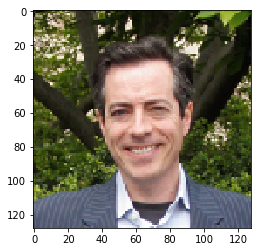

In [18]:
prof = load_image('../faces/play/bel_leaf2.jpg', shape)
plt.imshow(prof)

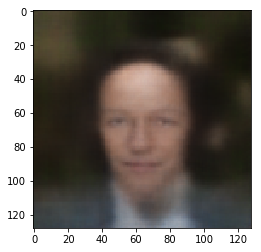

In [19]:
dec_prof = loaded_face_vae.run_one(prof).reshape(shape)
plt.imshow(dec_prof)

Huh, it appears that he becomes a 17th century composer. While the mouth is closed in the decoded image (which is not great), we can see some other features preserved quite well. Even the undershirt, shirt, and jacket have the right color. I suspect that the tree is too close in color to Prof. Belhumeur's hair, which is causing issues for the encoder. Let's try an image from the test portion of the dataset. This will have never been seen before by the net, but it will be in the format expected and might give some better results

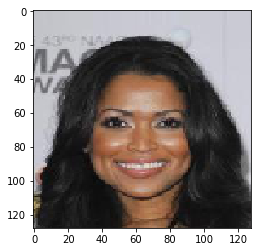

In [22]:
test_img = next(test_gen)[3]

plt.imshow(test_img)

We can run this image through the network. Remarkably, the output image ends up being quite similar to the input. The face is a little bit thinner and there is less detail, but we keep roughly the same eyebrow shape, eye shape, nose shape, motuh shape, and even some of the crease lines of the face!

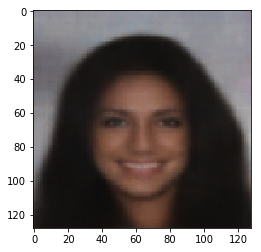

In [23]:
dec_test = loaded_face_vae.run_one(test_img)
plt.imshow(dec_test)

Okay cool, so now that I have a better example image, let's try some vector space math. The results are sometimes good, sometimes bad. Because I am just selecting 10000 random positive examples and 10000 random negative examples from the dataset, I could probably do better to reduce confounding factors.

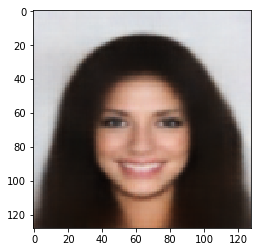

In [26]:
dec_test = loaded_face_vae.run_one(test_img, more=['attractive'], intensity=3.0)
plt.imshow(dec_test)

Whoa whoa whoa - what just happened? I tried making her more attractive with vector space, and the main result was that her skin got lighter. Here, we have some insight into the qualtiy of the labels provided with the CelebA dataset. There's a lot of bias with some of the labels. You cannot see it here, but applying "attractive" to images of men also tend to make them more female. We can infer that the labelers of the CelebA dataset generally had preferences for white women. On the bright side though, we notice that her eyes and mouth get larger, which are both commonly identified traits of attractiveness. The chin also becomes more defined and the face becomes skinnier. So it isn't all bad!

Let's try some other features:

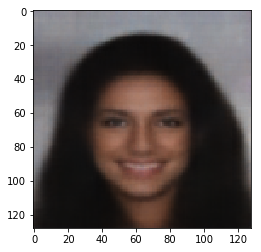

In [36]:
dec_test = loaded_face_vae.run_one(test_img, less=['black_hair'], more=['blond_hair'], intensity=4.0)
plt.imshow(dec_test)

Okay, so it appears that my net did not do a good job of encoding hair color well. This seems odd, because it always does a good job of recreating hair colors in the decoded images. Oh well, moving on

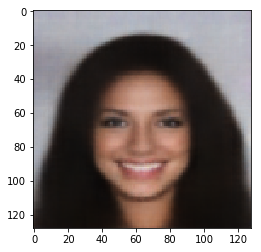

In [53]:
dec_test = loaded_face_vae.run_one(test_img, more=['smile'], intensity=3.0)
plt.imshow(dec_test)

We can make her smile even larger! Again, this also seems to lighten her skin. This likely means that people with lighter skin tend to smile more in the dataset, and conversely people with darker skin tend to smile less. Interesting!

And next, we can make her not smile. Similarly, note that the photo gets much darker.

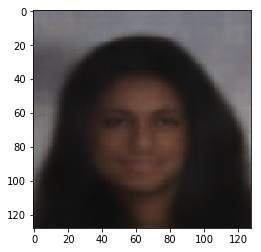

In [57]:
dec_test = loaded_face_vae.run_one(test_img, less=['smile'], intensity=2.0)
plt.imshow(dec_test)

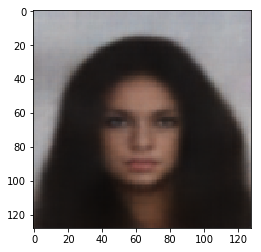

In [67]:
dec_test = loaded_face_vae.run_one(test_img, less=['no_beard'], intensity=4.0)
plt.imshow(dec_test)

Even turning the intensity way up, we can't seem to give her a beard. We do notice that her cheeks get darker, and her smile totally disappears. If I wanted to make this more user friendly, I would likely play around with combinations of attributes that lead to a desired result. no_beard would be a good one to make a smile go away

For one last test, we notice that making someone younger gives them a bigger smile, slightly lighter skin, and also soften face lines. Generally not bad!

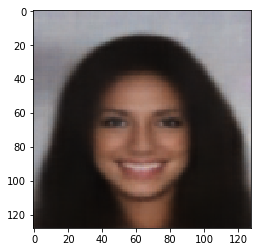

In [97]:
dec_test = loaded_face_vae.run_one(test_img, more=['young'], intensity=2.0)
plt.imshow(dec_test)

Overall, I am not incredibly happy about how the vector math ended up playing out. In future work, I would like to spend more time attempting to decorrelate attribute labels so we can get better results for face manipulation. We already see some decent results in some cases, and some bad ones in others. I omitted dozens of labels that come with the dataset, so there could be plenty more to play around with.

Finally, before I wrap up, let's see what my network does to President Obama and President Trump

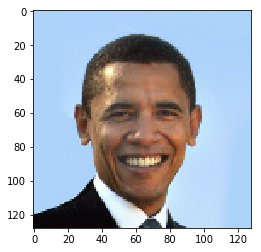

In [98]:
obama = load_image('../faces/play/obama_plain.jpg', shape)
plt.imshow(obama)

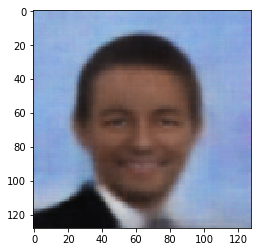

In [104]:
dec_obama = loaded_face_vae.run_one(obama).reshape(shape)
plt.imshow(dec_obama)

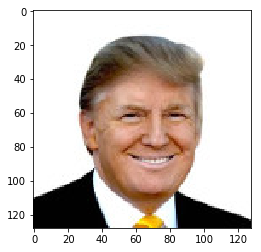

In [105]:
trump = load_image('../faces/play/trump3.jpg', shape)
plt.imshow(trump)

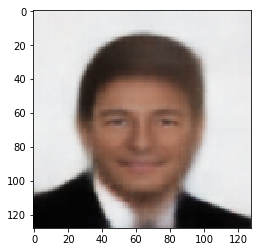

In [106]:
dec_trump = loaded_face_vae.run_one(trump)
plt.imshow(dec_trump)

Definitely not so great, but it is noticeable that both images result in reasonable faces. I wish the decoded Obama image had a more open smile, but at least there is something! The largest problem here is that, because of the pixel-wise loss function used, the network is extraordinarily sensitive to rotation of faces and translation of faces around the plane. The CelebA dataset uses only images that are centered based on facial points. Perhaps for future training, I could use some pertubations in the data, such as shearing / rotating / translation / etc. This might just lead to poor results though, so it would take a bit of work.

In conclusion, I created a convolutional variational autoencoder to reproduce faces by utilizing the CelebA dataset. This network was made to be very portable and easy to use (see Appendix A for an example of the exact same network being built and trained for MNIST data). I continued to play around with some vector math, using another easy interface I created. Here I demonstrated some clear bias in both the data and in the labels of the CelebA dataset, something that might be worth performing further research into. Hope you enjoyed!

## Appendix A: Testing on the MNIST dataset

Let's try using this on mnist data, just for a proof of concept. This is also a demonstration of how flexible the code I wrote above is. We are adapting it for a dataset with much smaller grayscale images and all it takes is setting params and running it!

In [15]:
# define the variables / paramters we need
shape = (28,28,1)
latent_dim = 8
int_dim = 100
nb_train = 60000
nb_validation = 10000
batch_size = 64
epochs = 10

model_name = 'mnist-4dim'
train_dir = '../mnist/training'
validation_dir = '../mnist/testing'
test_dir = '../mnist/testing'

In [16]:
train_gen, valid_gen, test_gen = create_generators(shape, train_dir, validation_dir, test_dir, batch_size=batch_size, color_mode='grayscale')
dir_structure(model_name)

Found 60000 images belonging to 2 classes.
Found 10000 images belonging to 2 classes.
Found 10000 images belonging to 2 classes.


In [17]:
mnist_vae = CVAE(shape, latent_dim, int_dim=int_dim, kl_weight=1, pixel_weight=1)
mnist_vae.compile_net(optimizer=keras.optimizers.Adamax(lr=0.001))
mnist_vae.model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_3 (InputLayer)             (None, 28, 28, 1)     0                                            
____________________________________________________________________________________________________
model_1 (Model)                  (None, 16)            481172                                       
____________________________________________________________________________________________________
model_2 (Model)                  (None, 28, 28, 1)     279317                                       
____________________________________________________________________________________________________
flatten_2 (Flatten)              (None, 784)           0                                            
___________________________________________________________________________________________

Epoch 1/10
937/937 [==============================] - 47s - loss: 169.4777 - val_loss: 126.6005

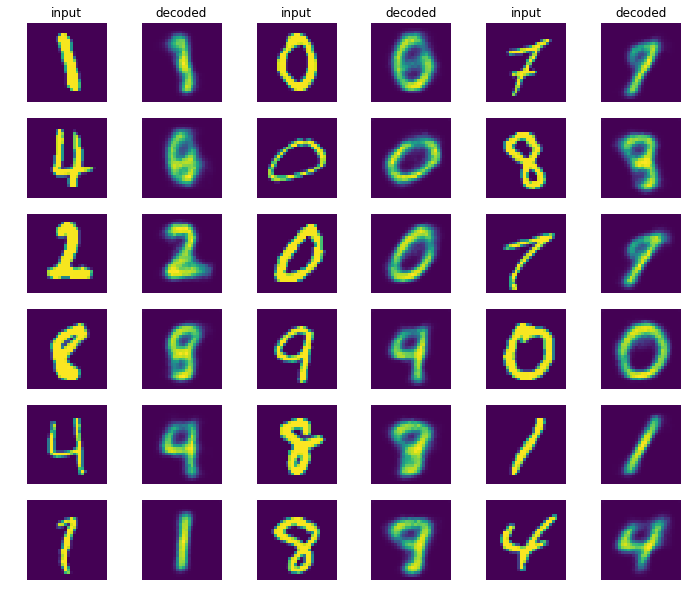

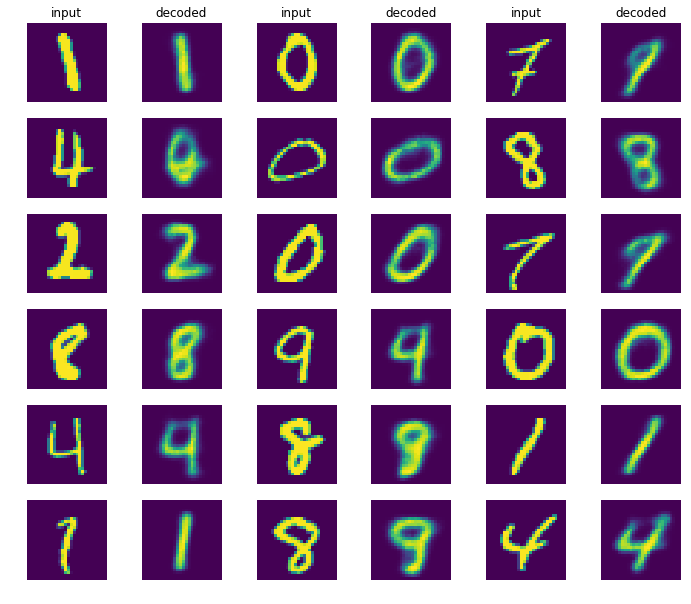

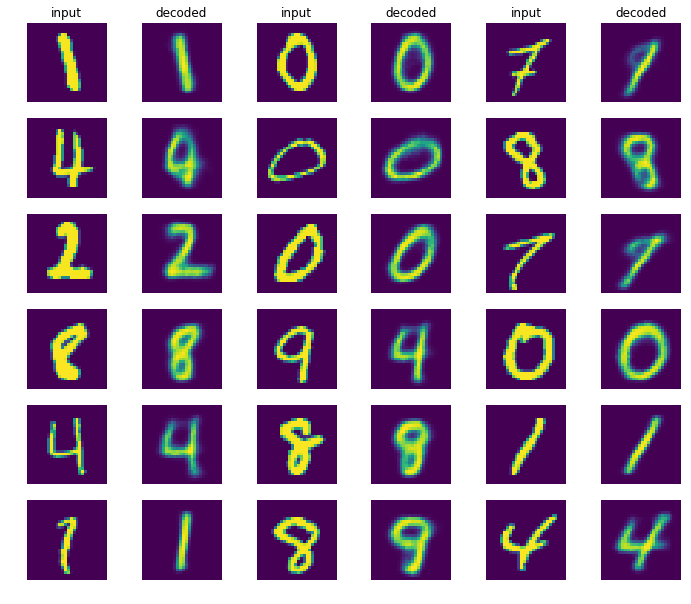

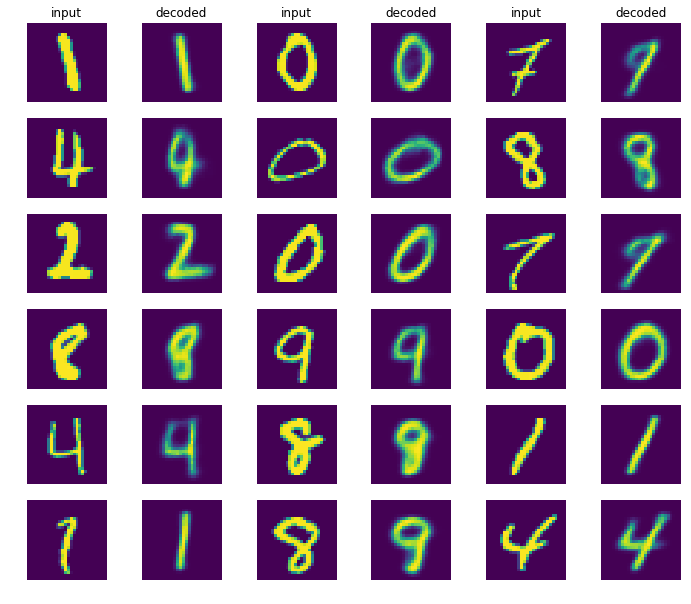

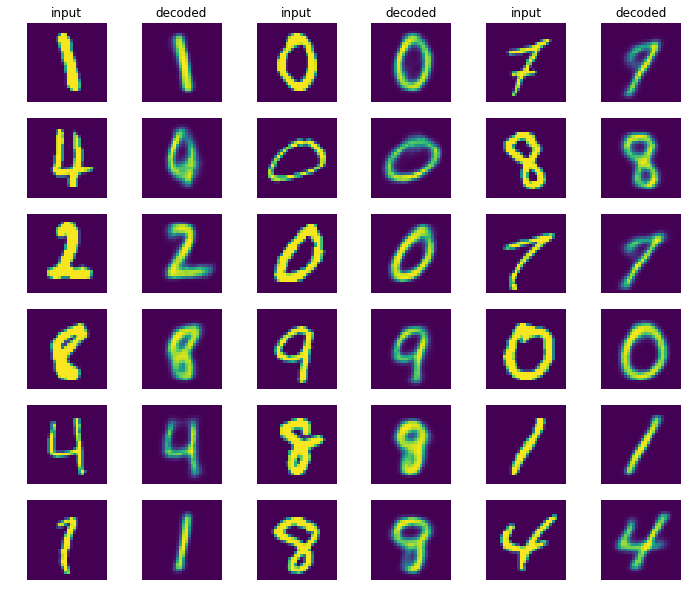

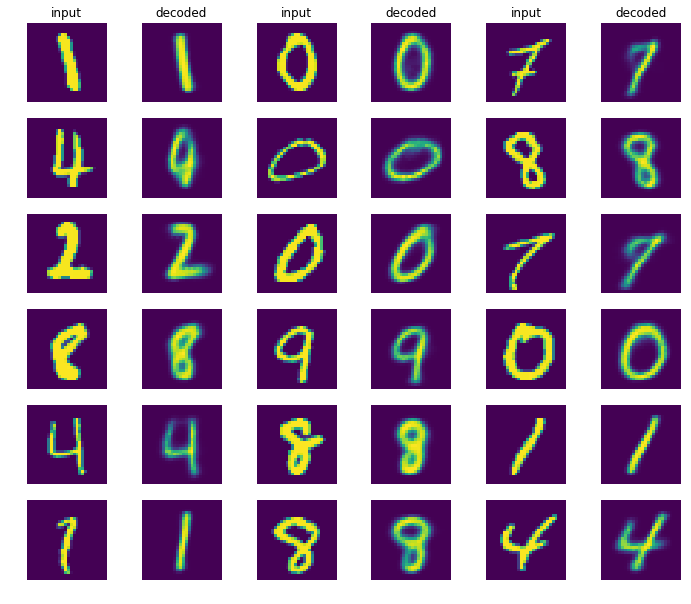

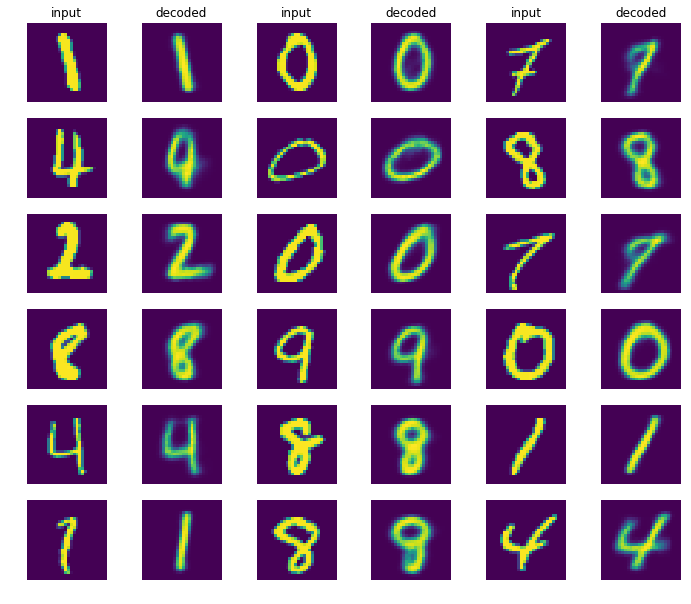

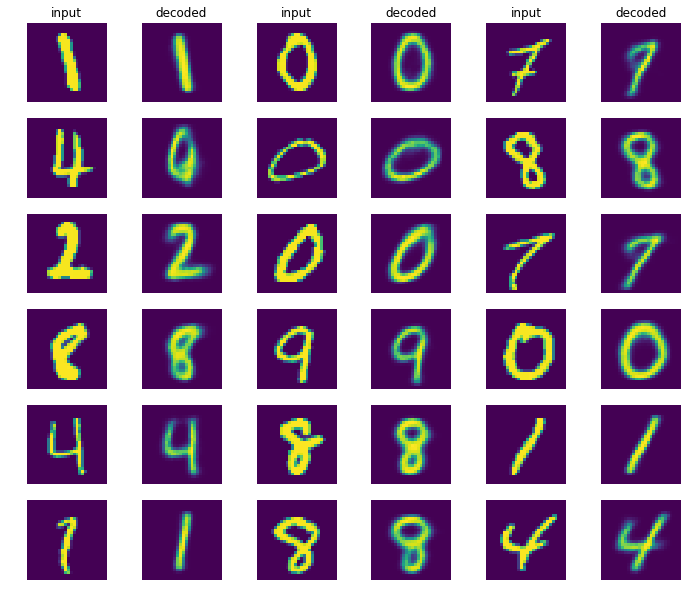

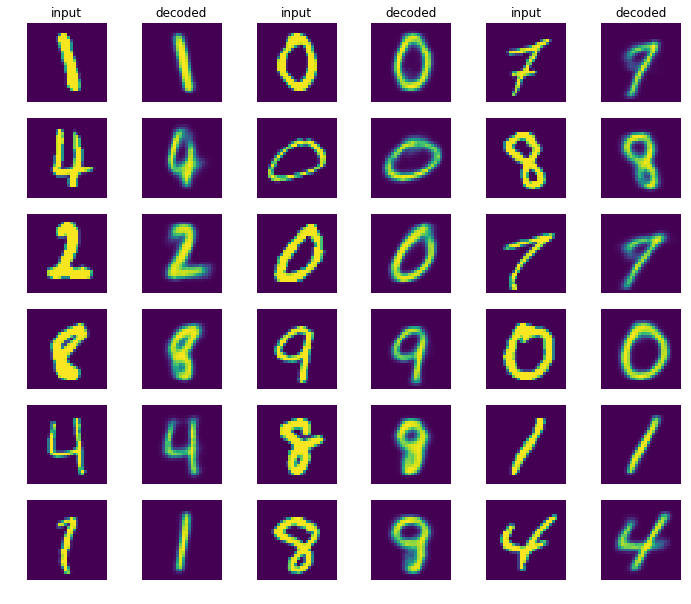

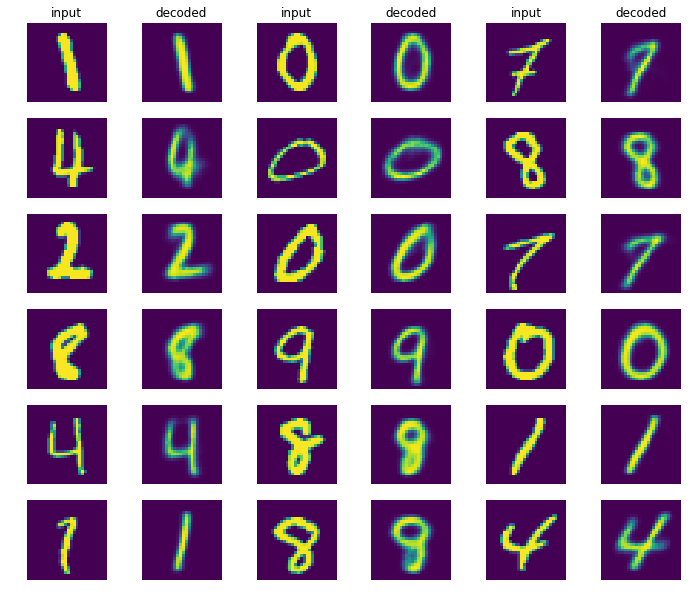

In [18]:
mnist_vae.train(
        train_gen,
        steps_per_epoch = (nb_train // batch_size),
        epochs = epochs,
        validation_data = valid_gen,
        validation_steps = (nb_validation // batch_size),
        verbose = 1,
        initial_epoch = 0,
        callbacks=build_callbacks(model_name, next(test_gen))
)

Not bad considering we are effectively compressing each image to four dimensions!

## Appendix B: Perceptual Loss (unable to get working)
I was unhappy with the mode collapse of the pixel-wise loss version of my CVAE, so I tried using a pre-trained VGG net for image recognition to calculate perceptual loss between the input image and the decoded image. What is listed here is my best attempt at it - I could never get my perceptual loss function working well enough. I am not sure what is wrong, but the loss will not budge, let alone converge.

Here is my code for building a vgg16 net

In [ ]:
def build_vgg16(img_width, img_height):

    model = Sequential()
    
    model.add(ZeroPadding2D((1, 1), input_shape=(img_width, img_height, 3)))
        
    model.add(Conv2D(64, (3, 3), activation='relu', name='conv1_1'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(64, (3, 3), activation='relu', name='conv1_2'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(128, (3, 3), activation='relu', name='conv2_1'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(128, (3, 3), activation='relu', name='conv2_2'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(256, (3, 3), activation='relu', name='conv3_1'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(256, (3, 3), activation='relu', name='conv3_2'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(256, (3, 3), activation='relu', name='conv3_3'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(512, (3, 3), activation='relu', name='conv4_1'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(512, (3, 3), activation='relu', name='conv4_2'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(512, (3, 3), activation='relu', name='conv4_3'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(512, (3, 3), activation='relu', name='conv5_1'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(512, (3, 3), activation='relu', name='conv5_2'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(512, (3, 3), activation='relu', name='conv5_3'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    
    return model

And a helper function to load a new vgg net, broken into pieces so we can get intermediate layer values

In [ ]:
def build_vgg(img_width, img_height, weights_path='vgg16_weights_tf.h5', breakpoints=None):
    tf_model = build_vgg16(128,128)
    tf_model.load_weights(weights_path)
    if breakpoints:
        models = [Sequential()]
        for layer in tf_model.layers[:breakpoints[0]]:
            models[0].add(layer)
        
        for i in range(1, len(breakpoints)):
            last_bp = breakpoints[i-1]
            bp = breakpoints[i]
            inp = Input(models[i-1].output_shape[1:])
            x = tf_model.layers[last_bp](inp)
            for layer in tf_model.layers[last_bp+1:bp]:
                x = layer(x)
                
            models.append(Model(inp,x))
            
        return models
    
    else:
        return tf_model

Similar to the pixel-wise loss CVAE above, we have to make a custom layer to calculate feature-wise loss for our VGG-CVAE

In [ ]:
# we need a different loss layer because we are gonna replace pixel-wise loss with feature-wise loss
# because Keras isn't powerful to handle the loss for a CVAE
# we have to create an actual loss layer to calculate it

# we still use the pixel-wise loss to help the net get started
# otherwise, it doesn't go very well
class VGG_CVAELossLayer(Layer):
    def __init__(self, latent_dim, image_size, kl_lambda=1, percep_lambda=1, pixel_lambda=1e-10, **kwargs):
        self.latent_dim = latent_dim
        self.image_size = image_size
        
        self.kl_l = kl_lambda
        self.pc_l = percep_lambda
        self.px_l = pixel_lambda
        
        self.is_placeholder = True
        
        super(VGG_CVAELossLayer, self).__init__(**kwargs)
        
    def calculate_kl(self, z_mean, z_log_sigma):
        # this is the Kullback Libeler divergence between the
        # distribution in latent space and the prio
        latent_loss = - 0.5 * K.sum(1 + K.clip(z_log_sigma, 1e-10, 1e10) - K.clip(K.square(z_mean), 1e-10, 1e10) - K.clip(K.exp(z_log_sigma), 1e-10, 1e10), axis = -1)
        
        return latent_loss
    
    def calculate_perceploss(self, real, decoded):
        # we have to scale up the images here, otherwise the output will be way too small
        return K.sum(K.square(real - decoded), (1, 2, 3))
    
    def calculate_loss(self, inputs):
        # first we will calculate kl
        x = inputs[0]
        z_mean = inputs[1][:,:self.latent_dim]
        z_log_sigma = inputs[1][:,self.latent_dim:]
        dec_x = inputs[2]
        
        kl_div = self.calculate_kl(z_mean, z_log_sigma)
        
        pixel_loss = self.image_size * K.mean(K.binary_crossentropy(dec_x + 1e-10, x + 1e-10), axis=-1)
        
        # then calculate perceptual losses
        #batch_size, _, _, _ = inputs[1].get_shape().as_list()
        batch_size, _ = inputs[0].get_shape().as_list()
        perceps = int((len(inputs) - 3) / 2)
        
        percep_loss = K.variable(np.zeros(batch_size,).astype('float32'), dtype='float32')
        
        for i in range(3, perceps+3):
            percep_loss += self.calculate_perceploss(inputs[i], inputs[i] + perceps)
            
        #percep_loss = percep_loss / perceps

        # this is the hacky way to calculate our loss
        # we use the inputs given to calculate the loss
        # and then return it for direct use for fitting
        return K.mean(self.kl_l * kl_div + self.pc_l * percep_loss + self.px_l * pixel_loss)
    
    def call(self, inputs):
        return self.calculate_loss(inputs)
    
    def compute_output_shape(self, input_shape):
        return (input_shape[0][0], 1)
    

And also a feature-wise loss net, using VGG. This also inherits from the AE abstract class created above and uses the same encoder / decover architecture, just different loss architecture. This makes everything pretty easy to set up

In [ ]:
class VGG_CVAE(AE):
    
    def __init__(self, image_shape, latent_dim, int_dim = 256, num_k=32, k_size=4, kl_weight=1, feature_weight=1, pixel_weight=1e-5):
        K.set_image_dim_ordering('tf')
        self.image_shape = image_shape
        self.latent_dim = latent_dim
        
        self.encoder = build_encoder(image_shape, latent_dim, int_dim, num_k, k_size)
        self.decoder = build_decoder(image_shape, latent_dim, int_dim, num_k, k_size)
        self.model = None

        self.attr_means = {}

        self._build_net(kl_weight, feature_weight, pixel_weight)

    def _build_net(self, kl_weight, feature_weight, pixel_weight):
        image_size = reduce(lambda x, y: x * y, self.image_shape)
        
        vgg_marks = [2,12,26]
        vggs = build_vgg(self.image_shape[0], self.image_shape[1], breakpoints=vgg_marks)
        for vgg in vggs:
            for layer in vgg.layers:
                layer.trainable = False
            
        raw_inp = Input(shape=(self.image_shape[0], self.image_shape[1], self.image_shape[2]))
        
        encoded = self.encoder(raw_inp)
        decoded = self.decoder(encoded)
        
        real_1 = vggs[0](raw_inp)
        real_3 = vggs[1](real_1)
        real_5 = vggs[2](real_3)
        
        gen_1 = vggs[0](decoded)
        gen_3 = vggs[1](gen_1)
        gen_5 = vggs[2](gen_3)
        
        flat_raw = Flatten()(raw_inp)
        flat_decoded = Flatten()(decoded)
        
        loss_layer = VGG_CVAELossLayer(self.latent_dim, image_size, kl_weight, 
                                       feature_weight, pixel_weight, name='cvae_loss')
        
        loss = loss_layer([flat_raw, encoded, flat_decoded, real_1, real_3, real_5, gen_1, gen_3, gen_5])

        self.model = Model(raw_inp, loss)

With all of that setup we can try training, but unfortunately it is not going to work. Let's try it anyways

In [ ]:
# define the variables / paramters we need
shape = (128,128,3)
latent_dim = 200
int_dim = 500
nb_train = 162770
nb_validation = 19867
batch_size = 8
epochs = 100

train_dir = '../faces/celebs/train'
validation_dir = '../faces/celebs/validation'
test_dir = '../faces/celebs/test'

train_gen, valid_gen, test_gen = create_generators(train_dir, validation_dir, test_dir, batch_size=batch_size)

dir_structure(model_name)

In [ ]:
face_vgg_vae = VGG_CVAE(shape, latent_dim, int_dim=int_dim, kl_weight=1, feature_weight=1, pixel_weight=1e-10)
face_vgg_vae.compile_net(optimizer=keras.optimizers.Adamax(lr=0.001))
face_vgg_vae.summary()

In [ ]:
face_vgg_vae.train(
        face_train_generator,
        steps_per_epoch = nb_train // batch_size,
        epochs = epochs,
        validation_data = face_validation_generator,
        validation_steps = nb_validation // batch_size,
        verbose = 0,
        initial_epoch = 0,
        callbacks=build_callbacks(model_name, next(test_gen))

## Appendix C: Generating faces with a GAN
So this net _runs_, but it does not do so particularly well. It just converges to noise, and lots of it. Most of the code is uncommented and very rough, namely because I did not spend the time to clean it up like I did with all code prior to this in the notebook. I'm just including this for record more than anything else. Maybe at some point I'll have time to come back to this project and actually attempt to get a GAN working!

In [ ]:
def build_generator(output_shape, latent_dims, num_k=64, k_size=5, int_dim=256):
    inp = Input(shape=(latent_dims,))
    x = Dense(int_dim, activation='relu')(inp)
    
    v_dim = output_shape[0] // 4
    h_dim = output_shape[1] // 4
    v_rem = output_shape[0] - (v_dim * 4)
    h_rem = output_shape[1] - (h_dim * 4)
    
    x = Dense(num_k // 2 * v_dim * h_dim, activation = 'relu')(x)
    x = Reshape((v_dim, h_dim, num_k // 2))(x)
    x = Dropout(0.4)(x)
    
    int_shape = (output_shape[0], output_shape[1], num_k)
    params = {'activation' : 'relu', 'padding' : 'valid'}
    p_params= {'pool_size' : (2,2), 'strides' : (2,2), 'padding' : 'same'}
    
    x = Conv2DTranspose(num_k, (k_size, k_size), strides=(1,1), activation = 'relu', padding='same')(x)

    x = Conv2DTranspose(num_k*4, (k_size, k_size), strides=(2,2), padding='same')(x)
    x = BatchNormalization(momentum=0.9)(x)
    x = Activation('relu')(x)
    
    pad, v_rem, h_rem = build_padding(v_rem, h_rem, 8)
    if pad:
        x = pad(x)
        
    x = Conv2DTranspose(num_k*2, (k_size, k_size), strides=(2,2), padding='same')(x)
    x = BatchNormalization(momentum=0.9)(x)
    x = Activation('relu')(x)
    
    pad, v_rem, h_rem = build_padding(v_rem, h_rem, 4)
    if pad:
        x = pad(x)
    
    '''x = Conv2DTranspose(num_k, (k_size, k_size), strides=(2,2), padding='same')(x)
    x = BatchNormalization(momentum=0.9)(x)
    x = Activation('relu')(x)
    
    pad, v_rem, h_rem = build_padding(v_rem, h_rem, 2)
    if pad:
        x = pad(x)'''
    
    x = Conv2DTranspose(num_k, (k_size, k_size), strides=(2,2), padding='same')(x)
    x = BatchNormalization(momentum=0.9)(x)
    x = Activation('relu')(x)
    
    x = MaxPooling2D(**p_params)(x)
    gen = Conv2D(output_shape[2], (4,4), padding = 'same', activation='sigmoid')(x)
    
    return Model(inp, gen)
    
    pad, v_rem, h_rem = build_padding(v_rem, h_rem, 4)
    if pad:
        x = pad(x)
        
    x = Conv2DTranspose(num_k*2, (k_size, k_size), strides=(2,2), activation = 'relu', padding='valid')(x)
    pad, v_rem, h_rem = build_padding(v_rem, h_rem, 2)
    if pad:
        x = pad(x)
        
    x = Conv2DTranspose(num_k, (k_size, k_size), strides=(2,2), activation = 'relu', padding='valid')(x)
    pad, v_rem, h_rem = build_padding(v_rem, h_rem, 1)
    if pad:
        x = pad(x)
        
    x = MaxPooling2D(**p_params)(x)
    gen = Conv2D(output_shape[2], (4,4), padding = 'valid', activation='sigmoid')(x)
    
    return Model(inp, gen)


def build_adversary(shape, num_k=64, k_size=4, int_dim=256):
    c_params = {'padding' : 'same', 'activation' : LeakyReLU(alpha=0.2)}
    p_params= {'pool_size' : (2,2), 'strides' : (2,2), 'padding' : 'same'}
    
    adv = Sequential()
    adv.add(Conv2D(num_k, (k_size, k_size), input_shape=shape, **c_params))
    adv.add(MaxPooling2D(**p_params))
    adv.add(Dropout(0.4))
    adv.add(Conv2D(num_k*2, (k_size, k_size), **c_params))
    adv.add(MaxPooling2D(**p_params))
    adv.add(Dropout(0.4))
    adv.add(Conv2D(num_k*4, (k_size, k_size), **c_params))
    adv.add(MaxPooling2D(**p_params))
    adv.add(Dropout(0.4))
    
    adv.add(Flatten())
    adv.add(Dense(int_dim, activation='relu'))
    adv.add(Dense(2, activation='sigmoid'))
    
    return adv

def build_GAN(shape, latent_dim, num_k=64, k_size=5, int_dim=256, g_opt='adamax', a_opt='adamax', gan_opt='adamax'):
    generator = build_generator(shape, latent_dim, k_size=k_size, num_k=num_k, int_dim=int_dim)
    generator.compile(loss='binary_crossentropy', optimizer=g_opt)
    
    adversary = build_adversary(shape, num_k=num_k, k_size=k_size, int_dim=int_dim)
    adversary.compile(loss='categorical_crossentropy', optimizer=a_opt)
    
    gan = Sequential()
    gan.add(generator)
    gan.add(adversary)
    
    gan.compile(loss='binary_crossentropy', optimizer=gan_opt)
    
    return generator, adversary, gan
    
    

In [ ]:
def demo_images(imgs, shape, filename=None):
    fig = plt.figure(figsize=(10,10))
    to_show = min(math.floor(math.sqrt(imgs.shape[0])), 4)
    for i in range(to_show**2):
        a = fig.add_subplot(to_show, to_show, i+1)
        a.spines['top'].set_color('none')
        a.spines['bottom'].set_color('none')
        a.spines['left'].set_color('none')
        a.spines['right'].set_color('none')
        a.tick_params(labelcolor='w', top='off', bottom='off', left='off', right='off')
        
        if len(shape) == 2:
            img = plt.imshow(imgs[i].reshape(shape), cmap=plt.get_cmap('gray'))
        else:
            img = plt.imshow(imgs[i].reshape(shape))
    plt.tight_layout()
    if filename:
        fig.savefig(filename)
    else:
        plt.show()
    
def fit_gan(gen, adv, gan, data_stream, epochs, steps_per_epoch, latent_dims, shape):
    # because we are doing our own training effectively
    # we gotta keep track of losses independant of tensorflow
    adv_loss = []
    gan_loss = []
    
    if shape[2] == 1:
        shape = (shape[0], shape[1])
    
    for i in range(epochs):
        adv_loss_ = []
        gan_loss_ = []
        for step in range(steps_per_epoch):
            real_imgs = next(data_stream)[0]
            cur_batch_size = real_imgs.shape[0]
            
            # make batches
            inp = np.random.uniform(-1.0, 1.0, size=(cur_batch_size, latent_dims)).astype('float32')
            gen_imgs = gen.predict(inp)

            # first let's train the adversary a bit
            try:
                X_batch = np.concatenate((real_imgs, gen_imgs))
            except Exception as e:
                print(real_imgs.shape)
                print(gen_imgs.shape)
                raise e
            y_batch = np.zeros([2*cur_batch_size,2])
            y_batch[cur_batch_size:,0] = 1
            y_batch[:cur_batch_size,1] = 1

            adv_loss_.append(adv.train_on_batch(X_batch, y_batch))

            # now we can train the whole GAN
            gaussian_noise = np.random.uniform(-1.0, 1.0, size=(cur_batch_size, latent_dims)).astype('float32')
            y_g = np.zeros([cur_batch_size,2])
            y_g[:,1] = 1
            
            gan_loss_.append(gan.train_on_batch(gaussian_noise, y_g))    
        
        adv_loss.append(sum(adv_loss_) / len(adv_loss_))
        gan_loss.append(sum(gan_loss_) / len(gan_loss_))
        
        if i % 2 == 0:
            demo_images(gen_imgs, shape, 'imgs{}.png'.format(i))
            #print(adv_loss)
            #print(gan_loss)

In [ ]:
shape = (28,28,1)
latent_dim = 100
batch_size = 128

g_opt = keras.optimizers.RMSprop(lr=0.0004, clipvalue=1.0, decay=3e-8)
a_opt = keras.optimizers.RMSprop(lr=0.0008, clipvalue=1.0, decay=6e-8)
gan_opt = keras.optimizers.RMSprop(lr=0.0004, clipvalue=1.0, decay=3e-8)
gen, adv, gan = build_GAN(shape, latent_dim, g_opt=g_opt, a_opt=a_opt, gan_opt=gan_opt)
            
epochs = 100
train_size = 8189
steps_per_epoch = train_size // batch_size

mnist_gen, _, _ = create_generators(shape, '../mnist/training/', batch_size=batch_size, color_mode='grayscale')

Again, we aren't actually going to run this. It takes about an hour for 100 epochs. Instead, here is a gif of it training. You can see that with mnist data it does _okay_

In [ ]:
fit_gan(gen, adv, gan, mnist_gen, epochs, steps_per_epoch, latent_dim, shape)

<img src="https://fat.gfycat.com/RemarkableSneakyJanenschia.gif">

So let's see how it does with faces (hint: not well at all). Again, we won't actually run this because it takes a very long time. Instead, here is a gif of it training. We can see that it makes vague facely shapes, but doesn't converge to much better

In [ ]:
shape = (64,64,3)
latent_dim = 256
batch_size = 16

g_opt = keras.optimizers.RMSprop(lr=0.0002, clipvalue=1.0, decay=3e-8)
a_opt = keras.optimizers.RMSprop(lr=0.0004, clipvalue=1.0, decay=6e-8)
gan_opt = keras.optimizers.RMSprop(lr=0.0002, clipvalue=1.0, decay=3e-8)

gen, adv, gan = build_GAN(shape, latent_dim, g_opt=g_opt, a_opt=a_opt, gan_opt=gan_opt)

In [ ]:
# GANs are a bit harder to train too, so we won't use built in fitting
epochs = 25
train_size = 162770

steps_per_epoch = train_size // batch_size

face_gen, _, _ = create_generators(shape, '../faces/celebs/train', batch_size=batch_size)
train_data_dir = '../faces/celebs/train'

fit_gan(gen, adv, gan, face_gen, epochs, steps_per_epoch, latent_dims, shape)

<img src="https://giant.gfycat.com/SmugLargeCanvasback.gif">